In [173]:
import json
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
import ast
import re
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import sklearn.manifold
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import os
%matplotlib inline

tweet_data = []
counter = 0

path = 'data/'
jsons = [jsonfile for jsonfile in os.listdir(path) if jsonfile.endswith('.json')]

# load in all json data files
# for index, js in enumerate(jsons):
#     with open(os.path.join(path, js)) as json_file:
#         for line in json_file:
#             tweet_data.append(json.loads(line))
#             counter += 1
              
with open('stream_test_fixed.json') as f:
    for line in f:
        tweet_data.append(json.loads(line))
        counter += 1

print(str(counter) + ' tweets loaded')

tweet_df = pd.DataFrame(tweet_data)

3325 tweets loaded


In [175]:
tweet_text_df = pd.DataFrame()
tweet_text_df['text'] = [s.split() for s in tweet_df['text'] if isinstance(s, str)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
topics = [' '.join(strings) for strings in tweet_text_df['text']]
dtm = vectorizer.fit_transform(topics) #.toarray()

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in topics]

dtm = vectorizer.fit_transform(stemmed_data)

terms = vectorizer.get_feature_names()

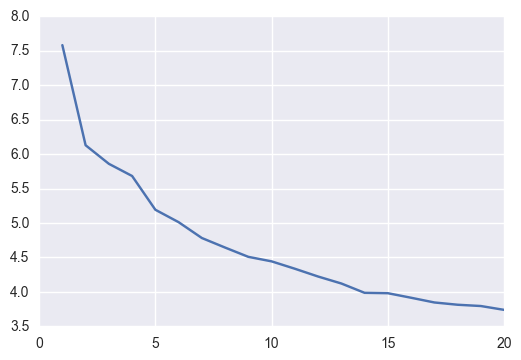

In [195]:
# PCA / Truncated SVD to deal with sparse data

from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)

u, s, vt = randomized_svd(centered_dtm, n_components=20, n_iter=5, random_state=None)

plt.xlim([0,20])
plt.plot(range(1,len(s)+1),s)


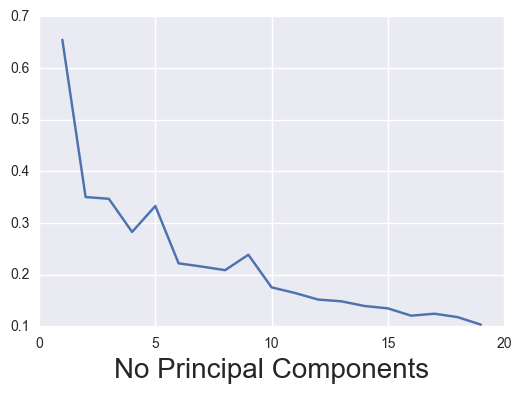

In [153]:
# Silhouette Score
ss = []
maxlen = len(u)
for k in range(1,20):
    vectorsk = u[:,:k] @ np.diag(s[:k])
    kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk)
    labelsk = kmeans.labels_
    ss.append(metrics.silhouette_score(vectorsk,labelsk,metric='euclidean'))
    
plt.plot(range(1,20),ss)
plt.xlabel('No Principal Components',size=20)

In [209]:
from sklearn.metrics.pairwise import cosine_similarity

# fit LSA with 5 principal components
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(5, algorithm='randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
dist_matrix = 1 - cosine_similarity(dtm_lsa)

pd.DataFrame(lsa.components_,index=['comp1','comp2','comp3','comp4','comp5'],columns=terms)

,000,098jame,0hour,10,100,11,12,13,16,1776_yanke,...,êtr,être,дональд,президентом,ретвитните,станет,сша,твит,трамп,этот
comp1,0.010558,0.002806,0.002856,0.028295,0.004383,0.021535,0.002110,0.001439,0.007033,0.002113,...,0.000954,0.001764,0.002269,0.002269,0.002269,0.002269,0.002269,0.002269,0.002269,0.002269
comp2,-0.006251,-0.008700,-0.002168,0.014156,-0.002632,-0.018287,-0.003784,-0.002208,-0.005009,0.000953,...,-0.000188,-0.000551,-0.007191,-0.007191,-0.007191,-0.007191,-0.007191,-0.007191,-0.007191,-0.007191
comp3,0.008766,-0.001075,-0.000757,-0.051189,0.001518,-0.027713,0.000398,-0.002069,-0.007481,0.000092,...,-0.001472,-0.001519,-0.008313,-0.008313,-0.008313,-0.008313,-0.008313,-0.008313,-0.008313,-0.008313
comp4,-0.005435,0.000317,0.000017,-0.024558,-0.002787,-0.029377,-0.003519,-0.002629,-0.008110,0.000613,...,-0.000579,-0.000228,-0.007456,-0.007456,-0.007456,-0.007456,-0.007456,-0.007456,-0.007456,-0.007456
comp5,0.016582,-0.002569,0.005412,-0.049767,0.002900,0.017800,-0.001894,0.000676,0.001971,0.003558,...,-0.000677,0.005199,-0.005622,-0.005622,-0.005622,-0.005622,-0.005622,-0.005622,-0.005622,-0.005622


In [233]:
for i in range(5):
    top = np.argsort(vt[i])[::-1]
    topterms = [terms[top[f]] for f in range(24)]
    print(i,topterms)
    
# get better defined categories after loading higher volume of tweets
# current categories: {0 : pro_hillary, 1 : voting (?), 2 : misc (?), 3 : anti_hillary, 4 : pro_trump }

0 ['https', 'clinton', 'elect', 'point', 'utah', 'lead', '10', 'break', 'hold', 'election2016', 'rt', 'scandal', 'campaign', 'hillari', 'wikileak', 'day', 'video', 'imwithh', 'watch', 'love', 'thehil', 'doesn', 'final', 'declar']
1 ['elect', 'day', 'tomorrow', 'vote', 'presidenti', 'night', '2016', 'firework', 'make', 'hillari', 'election2016', 'eve', 'cancel', 'just', 'big', 'watch', 'electionday', 'today', 'sure', 'let', 'cast', 'amp', 'nbcwashington', 'ca']
2 ['vote', 'just', 'cast', 'debat', 'nbc4dc', 'nbcwashington', 'think', 'win', 'told', 'https', 'pleas', 'pointlessblog', 'hillari', 'tomorrow', 'let', 'trump', 'fl', 'ananavarro', 'make', 'america', 'explain', 'symbol', 'protest', 'sure']
3 ['hillari', 'clinton', 'fbi', 'email', 'hillaryclinton', 'campaign', 'vote', 'wikileak', 'presid', 'foundat', 'obama', 'imwithh', 'scandal', 'ana', 'navarro', 'leak', 'la', 'use', 'chelsea', 'firework', 'cnn', 'power', 'trumpmovementus', 'absolut']
4 ['think', 'just', 'win', 'debat', 'told', 

0.384366130729


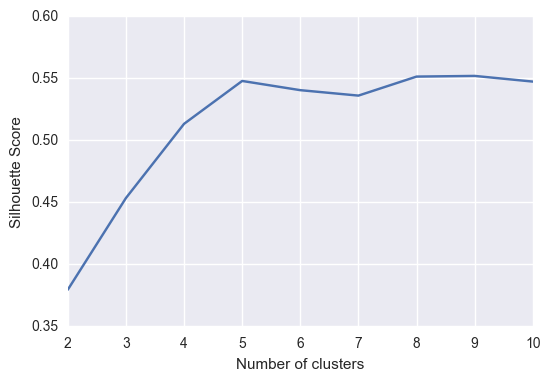

In [148]:
# Evaluating number of clusters for k-means

k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(dtm_lsa)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

# Evaluate clusters for K-Means++ Clustering
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=100)
kmeans.fit_predict(dtm_lsa)
labels = kmeans.labels_

# Evaluate number of clusters with silhouette coefficient
scoeff = metrics.silhouette_score(dtm_lsa, labels, metric='euclidean')
print(scoeff)

def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
        kmeans.fit_predict(dtm_lsa)
        s[k] = metrics.silhouette_score(dtm_lsa,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
sc_evaluate_clusters(dtm_lsa,10)

In [217]:
from sklearn.manifold import MDS

# Performing k-means++ with 5 clusters
nclusters = 5
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit_predict(dtm_lsa)
clusters = kmeans.labels_.tolist()

# Multidimensional Scaling for 2-dimensional plotting 
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
p = mds.fit_transform(dist_matrix)
x_vals = p[:, 0]
y_vals = p[:, 1]

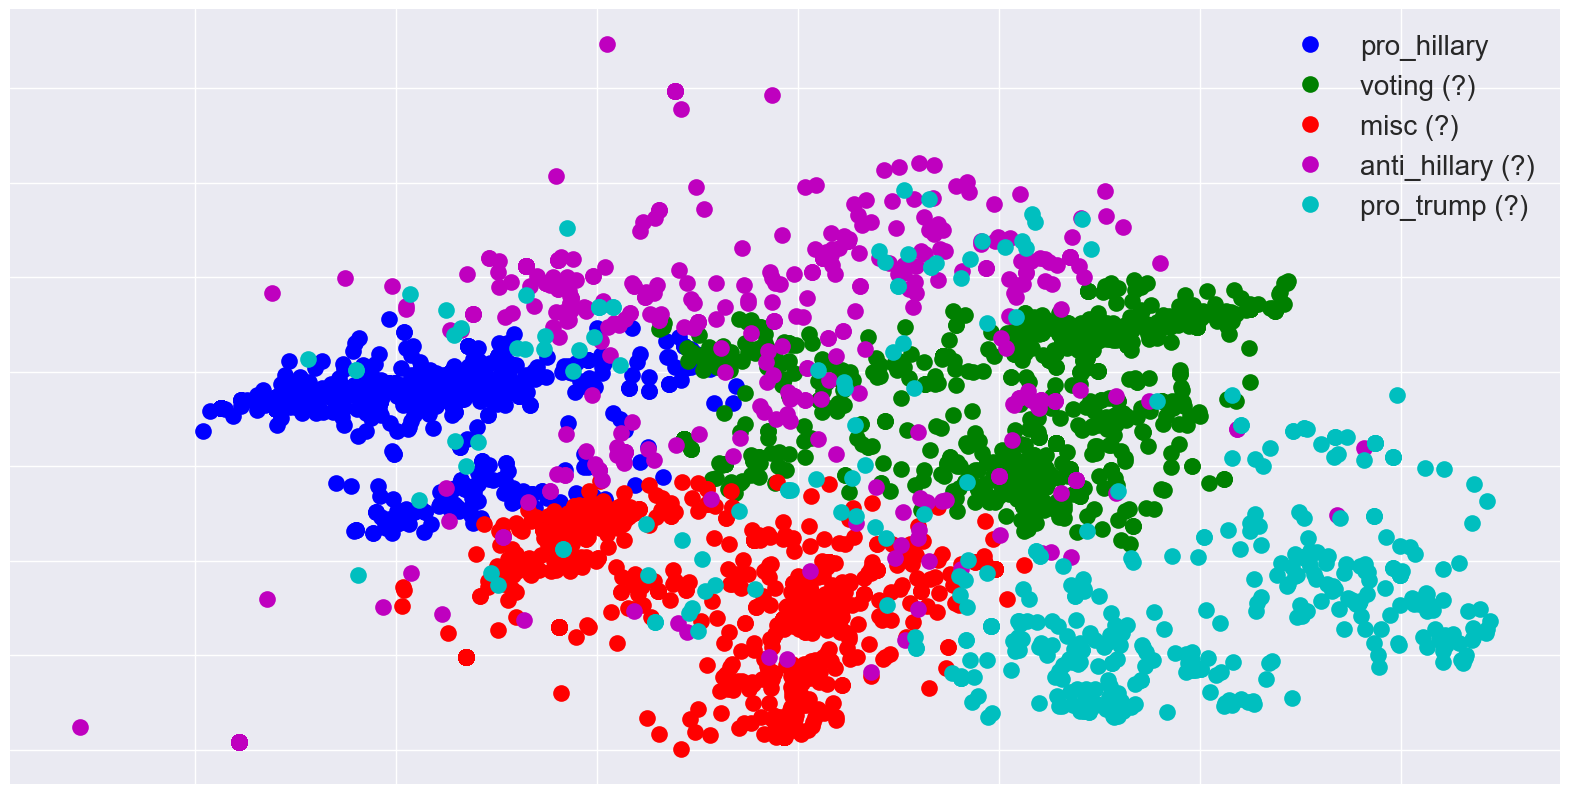

In [234]:
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'm', 4: 'c'}

cluster_names = {0: 'pro_hillary', 
                 1: 'voting (?)', 
                 2: 'misc (?)', 
                 3: 'anti_hillary (?)', 
                 4: 'pro_trump'}

df = pd.DataFrame(dict(x=x_vals, y=y_vals, label=clusters)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(20, 10)) 
ax.margins(0.05)

# plot groups 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1,prop={'size':20})
    
plt.show()